## Red U-Net para la segmentación del iris

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans
import shutil

from skimage import data

In [4]:
from keras.models import load_model

model = load_model('Iris_unet_d5.h5')
model.summary()

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 160, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [5]:
def create_segmented_dir(path_dataset, samples):
    '''
    Crea la mimsma estructura con la que cuenta el dataset de CASIA en la que se guardará 
    las imágenes segmentadas.
    '''
    # creamos carpeta en la que guardaremos las imágenes
    os.mkdir(path_dataset)
    for i in range(1, samples+1): # 108 sujetos
        sample = path_dataset + os.sep + "%.3d" % i
        os.mkdir(sample)
        for j in range(1,3): # 2 sesiones
            session = sample + os.sep + str(j)
            os.mkdir(session)
    print("-> Estructura de directorios creados satisfactoriamente.")
    

def copy_all_samples(path_samples, destination_directory):
    '''
    Copia todas las muestras del dataset de CASIA a un único directorio.
    '''
    os.mkdir(destination_directory)
        
    for root, dirs, files in os.walk(path_samples):
        for file in files:
            path_file = os.path.join(root,file)
            shutil.copy2(path_file,destination_directory)   
    print("-> Muestras copiadas satisfactoriamente.")

In [6]:
# ejecutar una única vez
# create_segmented_dir('CASIA-IrisV1-Segmented', 108)
# copy_all_samples('CASIA-IrisV1', 'dataset')

In [12]:
def testGenerator(directory,num_image,target_size = (320,320),flag_multi_class = False):
    '''
    Genera las muestras que se le pasarán al método predecir de la red preentrenada.
    
    Parámetros:
    directory -- directorio dónde se encuentran las muestras a generar
    num_image -- número máximo de imágenes que queremos generar
    target_size -- shape de de la muestra
    flag_multi_class -- (de momento mantener pero no nos es útil)
    '''
    i = 0
    for root, dirs, files in os.walk(directory):
        if files: # si es directorio hoja
            for file in files:
                if i == num_image:
                    break # sólo queremos x imágenes para probar
                path_file = os.path.join(root,file)
                img = cv2.imread(path_file,0)
                img = img / 255
                img = trans.resize(img,target_size)
                img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
                img = np.reshape(img,(1,)+img.shape)
                i += 1
                yield img

def get_samples_names(directory):
    '''
    Devuelve los nombres de las muestras(los que se encuentran en los directorios hoja)
    
    Parámetros:
    directory -- directorio de cuyos subdirectorios hoja se quiere el nombre 
    '''
    names = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            names.append(str(file))
            
    return names

def saveResult(save_path, name_path,npyfile,flag_multi_class = False):
    '''
    Guarda los imágenes segmentadas resultado de la red preentrenada
    
    Parámetros:
    save_path -- ruta en la que se guardarán las muestras segmentadas
    name_path -- directorio del que cogeremos los nombres de las muestras
    npyfile -- resultado de la red preentrenada
    flag_multi_class -- (de momento mantener pero no nos es útil)
    '''
    dim = (320, 280) # dimensioned de las muestras del dataset
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
        names = get_samples_names(name_path)
    #     for item, name in zip(npyfile, names):
    #         img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
    #         cv2.imwrite(os.path.join(save_path,name),img) # con cv2 da problemas
        for i,item in enumerate(npyfile):
            img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
            img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            io.imsave(os.path.join(save_path,names[i]),img)

In [13]:
testGene = testGenerator("CASIA-IrisV1", 10) #len(os.listdir('dataset')))
results = model.predict(testGene,15,verbose=1)
saveResult("CASIA_Segmented","CASIA-IrisV1",results)

10/10 [==============================] - 11s 1s/step


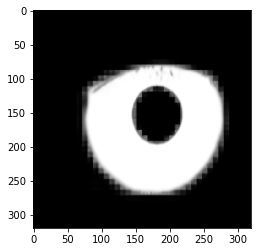

In [10]:
img = results[0][:,:,0]
plt.imshow(img, cmap='gray');

La segmentación se ha realizado correctamente, los únicos inconvenientes que aparecen puede ser que los bordes límbico y pupilar no aparecen bien definidos(están pixelados), y aparte cómo en el método `testGenerator` se cambió la resolución de la imagen a una cuadrada de 320x320, se aprecia que tanto la pupila como el iris están ovalados.

Sin embargo en el método `saveResult` se corrige el problema de la resolución, ya que volvemos a redimensionar la muestra segmentada para que cuente con las mismas dimensiones que las muestras originales.

Vamos a superponer la muestra segmentada sobre la muestra completa del ojo para comprobar que ha aislado correctamente el iris.

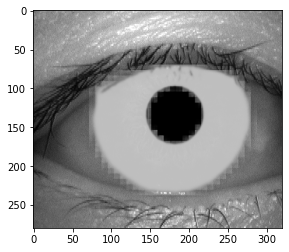

In [14]:
from PIL import Image

import numpy as np

path_img = "CASIA_v1" + os.sep + "001_1_1.bmp"
path_back = "CASIA_Segmented" + os.sep + "001_1_1.bmp"

image = Image.open(path_img)
background = Image.open(path_back)

background.paste(image, (0, 0), image)
plt.imshow(background, cmap='gray');

### 1. Aplicación de operadores morfológicos sobre la imagen segmentada

Este proceso consistirá en suavizar los bordes pixelados mediante operadores morfológicos como paso previo antes de aplicar el detector de Canny.

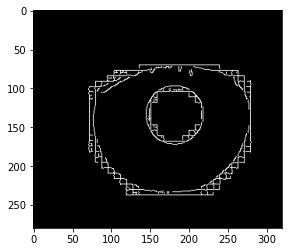

In [15]:
# Deteccion de bordes con Canny sin aplicar operadores morfológicos(suavizar los bordes)
path_img = "CASIA_Segmented" + os.sep + "001_1_1.bmp"
img = cv2.imread(path_img)
edges = cv2.Canny(img, 10, 255)
plt.imshow(edges, cmap='gray');

Para el suavizado de las muestras segmentadas se realizarán los siguientes pasos.

- Se binarizará la muestra
- Se aplicarán operadores morfológicos
- Se binarizará nuevamente.

In [26]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
(thresh, binRed) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY) # se binariza
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) # se aplica operadores morfológicos(vigilar iteraciones)
(thresh, binRed) = cv2.threshold(opening, 128, 255, cv2.THRESH_BINARY) # se binariza nuevamente

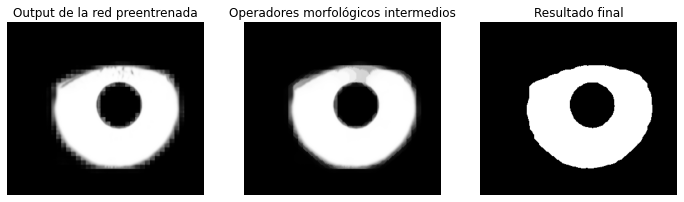

In [27]:
fig, axes = plt.subplots(1,3, figsize=(12,12))
axes[0].imshow(img,cmap='gray')
axes[0].set(title="Output de la red preentrenada")
axes[0].axis('off')
axes[1].imshow(opening,cmap='gray')
axes[1].set(title="Operadores morfológicos intermedios");
axes[1].axis('off')
axes[2].imshow(binRed,cmap='gray')
axes[2].set(title="Resultado final");
axes[2].axis('off');

In [22]:
# creamos un nuevo directorio para guardar las muestras segmentadas con mayor calidad
os.mkdir("CASIA_Segmented_v2")
cv2.imwrite("CASIA_Segmented_v2"+ os.sep + "001_1_1.bmp", binRed)# guardamos muestra

Superponemos la imagen suavizada sobre la muestra, se observa que se ajusta mejor que el resultado anterior.

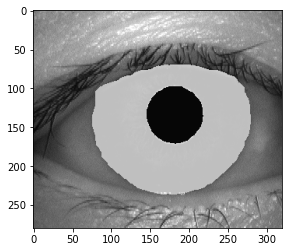

In [25]:
background = Image.open("CASIA_Segmented_v2"+ os.sep + "001_1_1.bmp")

background.paste(image, (0, 0), image)
plt.imshow(background);

Ahora aplicamos el detector de Canny nuevamente pero con la muestra suavizada.

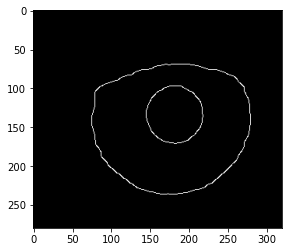

In [31]:
edges = cv2.Canny(binRed, 10, 255)
plt.imshow(edges, cmap='gray');

In [33]:
# creamos un nuevo directorio para guardar las muestras con los bordes detectados
if not os.path.exists("CASIA_Edge"):
    os.mkdir("CASIA_Edge")
cv2.imwrite("CASIA_Edge"+ os.sep + "001_1_1.bmp", edges)# guardamos muestra

True

Detecta a la perfección el iris, consiguiendo aislarlo del resto del ojo, pestañas incluídas, aunque estas se procesarán de una mejor manera posteriormente con el Hough de líneas.

### 2. Detección del iris
Se usará el método de Wildes el cuál se basa en la aplicación de la transformada de Hough adaptada para la detección de círculos (en lugar de líneas). Este enfoque es ampliamente usado debido a su precisión.

Este método implica tener que realizar 2 iteraciones(2 aplicaciones de Hough circular), una para localizar el borde límbico y la otra para localizar el borde pupilar. Como paso previo a aplicar Hough, se usará el detector de bordes de Canny.

### 2.1 Hough con OpenCV

Para el dataset de Casia, el radio del iris se encuentra en el rango de 90-150 píxeles, mientras que el radio de la pupila entre 28-75 píxeles

In [38]:
path_img = "CASIA_Edge" + os.sep + "001_1_1.bmp"

1 circle/s were found
center of iris:  (177, 136)
radius of iris:  101


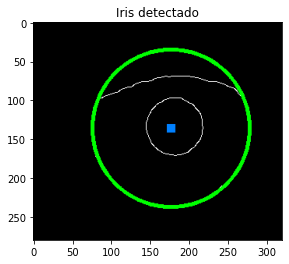

In [39]:
img = cv2.imread(path_img) # trabajamos con la muestra a la que ya hemos aplicado Canny
output = img.copy()
gray_img = cv2.imread(path_img, 0)

# Hough circular
# esta función de openCV devuelve una tupla de la forma(x_centro, y_centro, radio)
circles = cv2.HoughCircles(gray_img,
                          cv2.HOUGH_GRADIENT, # method -> único
                          1.1,# dp
                          155, # minDist
                          param1=50,
                          param2=30,
                          minRadius=28, # radio mínimo del iris que se está intentando localizar
                          maxRadius=150) # radio máximo "...."

# tiene que haber detectado como mínimo un círculo
if circles is not None:
    print(len(circles), "circle/s were found")
    circles = np.round(circles[0, :]).astype("int")
    
    for (x_center, y_center, radius) in circles:
        print("center of iris: ", (x_center,y_center))
        print("radius of iris: ", radius)
        # dibujamos el círculo correspondiente al iris
        cv2.circle(output, (x_center,y_center), radius, (0, 255, 0), 4)
        # dibujamos el centro
        cv2.rectangle(output, (x_center - 5, y_center - 5), (x_center + 5, y_center + 5), (0, 128, 255), -1)
        
    # show the output image
#     cv2.imshow("Iris detectado", np.hstack([img, output]))
#     cv2.waitKey(0)
    plt.imshow(output)
    plt.title("Iris detectado")
else:
    print("ERROR: Not circles were found.")


### Recortar iris

Una vez localizadas las coordenadas del iris ya se puede recortar de la muestra original, la parte correspondiente al iris.

Solución basada en: https://stackoverflow.com/questions/36911877/cropping-circle-from-image-using-opencv-python

In [41]:
height,width = gray_img.shape
mask = np.zeros((height,width), np.uint8)

circle_img = cv2.circle(mask,(x_center,y_center),radius,(255,255,255),thickness=-1)
circle_copy = circle_img.copy()
# plt.imshow(circle_img, cmap='gray');
path_img = "CASIA_v1" + os.sep + "001_1_1.bmp"
img = cv2.imread(path_img)
masked_data = cv2.bitwise_and(img, img, mask=circle_img)
# plt.imshow(masked_data, cmap='gray');
_,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
# plt.imshow(thresh, cmap='gray');

(contours, hierarchy) = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours = np.float32(contours)
x,y,w,h = cv2.boundingRect(contours[0])
crop = masked_data[y:y+h,x:x+w]


cv2.imshow('Cropped Eye',crop)
cv2.waitKey(0)
cv2.destroyAllWindows()